#Develop log

24.04.19
- 학습이 안 되던 문제를 해결. label의 데이터 값이 0, 1로 정수형인데, 이 녀석을 부동소수형으로 변형하여 loss를 계산하던 것이 문제인듯함. label의 값을 LongTensor로 변환하여 loss값을 구하였더니 정상적으로 학습이 됨을 확인함. 
- 다른 문제로 모델의 성능이 상당히 떨어짐을 확인함. validation의 정확도를 기준으로 5epoch에서 정확도가 최대였음. 해당 epoch에서의 train의 정확도는 72% 가량 나옴. 좀 더 정확도를 올릴 수 있는 방법을 찾아보는 것이 좋을듯 함.
- 위와 같이 정확도가 크게 올라가지 못하는 이유로 다음과 같이 추정.
fasttext모델을 학습에 사용하는 코퍼스가 아닌 다른 코퍼스를 사용하여 학습함. 여기서부터 오는 약간의 간극과 더불어 학습에 사용된 코퍼스가 맞춤법이 부정확한 댓글의 특성에 더해져 더욱 큰 성능의 감소를 가져왔다고 추정됨.

24.04.23
- float 이어도 정상적으로 학습이 됨...? 이전 버전의 내용을 확인해봐야 할 필요가 있어보임

In [1]:
import pandas as pd
import hgtk
from tqdm import tqdm
import fasttext

In [2]:
def decompose(forms:list):
    word = ''
    for form in forms:
        try:
            if hgtk.checker.is_hangul(form):
                for s in form:
                    a, b, c = hgtk.letter.decompose(s)
                    if not a:
                        a = '-'
                    if not b:
                        b = '-'
                    if not c:
                        c = '-'
                    word = word + a + b + c
        except TypeError as e:
            print(form)
    return word

In [3]:
def compose(jamo_sequence:list):
    tokenized_jamo = []
    index = 0

    while index < len(jamo_sequence):
        if not hgtk.checker.is_hangul(jamo_sequence[index]):
            tokenized_jamo.append(jamo_sequence[index])
            index = index + 1

        else:
            tokenized_jamo.append(jamo_sequence[index:index + 3])
            index = index + 3

    word = ''
    try:
        for jamo in tokenized_jamo:

            if len(jamo) == 3:
                if jamo[2] == "-":
                    word = word + hgtk.letter.compose(jamo[0], jamo[1])
                else:
                    word = word + hgtk.letter.compose(jamo[0], jamo[1], jamo[2])
            else:
                word = word + jamo

    except Exception as exception:
        if type(exception).__name__ == 'NotHangulException':
            return jamo_sequence

    return word

In [4]:
fast_model = fasttext.load_model("fasttext.bin") # 모델 로드

In [5]:
def transform(word_sequence):
    return [(compose(word), similarity) for (similarity, word) in word_sequence]

In [6]:
fast_model.get_word_vector(decompose(['제주도']))

array([-0.23002268,  0.39805633, -0.595214  , -0.4201808 ,  0.06841939,
       -0.23568943,  0.33469296,  0.09796971,  0.10487619,  0.17936371,
       -0.04858068,  0.11436544, -0.18841325, -0.1625356 ,  0.03736197,
        0.23201014, -0.30488858, -0.11117312, -0.21404381, -0.01474717,
        0.13891964, -0.6124201 , -0.3584761 , -0.41327453, -0.21037365,
        0.30367267, -0.06418942,  0.20489423, -0.15140772,  0.34683898,
       -0.08985352,  0.21257268, -0.07074974,  0.20376125, -0.09280302,
       -0.33641914, -0.32314423, -0.19665879, -0.25710115,  0.04477051,
       -0.0592188 , -0.04977519,  0.60128856, -0.15175302, -0.6904205 ,
       -0.4166109 ,  0.2812419 ,  0.1937623 , -0.70656985, -0.4241435 ,
        0.8790712 , -0.02911854, -0.02107281,  0.7127032 ,  0.61294305,
       -0.10936469,  0.17948501, -0.3176769 ,  0.06604326,  0.24650899,
       -0.4777825 ,  0.52821845, -0.32548603, -0.3195687 ,  0.32848126,
        0.50072765,  0.13473417,  0.10986972, -0.09630211,  0.52

In [6]:
from torch.utils.data import random_split, DataLoader, Dataset, TensorDataset
from torch import nn
import torch.nn.functional as F
import torch
import numpy as np
import matplotlib.pyplot as plt

In [23]:
class CustomDataset(Dataset):
    def __init__(self, csv_dir, num_word, transform = None, target_transform=None):
        self.df = pd.read_csv(csv_dir).sample(frac=1)[:5120]
        self.transform = transform
        self.target_transform = target_transform
        self.num_word = num_word
        self.labels = torch.from_numpy(self.df['label'].values).type(torch.float32)
            
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, i):
        sent = self.df['morphologized_sent'].iloc[i]
        padded_vec = torch.zeros((self.num_word, fast_model.get_dimension()), dtype = torch.float32)
        
        sent2vec = [] 
        for w in sent:
            if w.rstrip():
                sent2vec.append(fast_model.get_word_vector(decompose(w)))
        sent2vec = np.array(sent2vec)
        len_sent = len(sent2vec)
        if len_sent > self.num_word:
            len_sent = self.num_word
        padded_vec[(self.num_word - len_sent):] = torch.from_numpy(sent2vec[:len_sent])
        return (padded_vec, self.labels[i])

In [24]:
dataset = CustomDataset('./morphologized_ratings.csv', num_word=32)

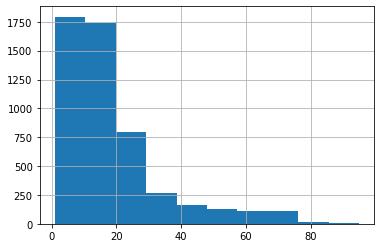

count    5120.000000
mean       18.410352
std        15.474022
min         1.000000
25%         8.000000
50%        14.000000
75%        22.000000
max        95.000000
dtype: float64

In [205]:
sent_len = [len(s.split()) for s in dataset.df['morphologized_sent']]
pd.Series(sent_len).hist()
plt.show()
pd.Series(sent_len).describe()

In [210]:
len(sent_len)

5120

In [208]:
from collections import defaultdict

dic = defaultdict(int)

for n in sent_len:
    dic[n] += 1

In [211]:
i = 0
for k, v in dic.items():
    i += v
    
    if i//len(sent_len) * 100 > 90:
        print(k, v)

83 1


In [25]:
train_size = int(len(dataset) * 0.8)
valid_size = len(dataset) - train_size
batch_size = 32

In [26]:
train_data, valid_data = random_split(dataset, [train_size, valid_size])

In [27]:
train_dataloader = DataLoader(train_data, batch_size = batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_data, batch_size = batch_size, shuffle=True)

In [28]:
train_sent, train_label = next(iter(train_dataloader))
print(train_sent)
print(train_label)
print(train_sent.size())

tensor([[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [-4.5480,  1.2421, -1.7386,  ..., -1.6190,  2.8765,  0.8209],
         [-1.7304,  2.6166,  0.5414,  ...,  1.4530, -1.5455, -1.4455],
         [ 1.2498, -0.2578, -1.8190,  ..., -1.3858,  1.6934, -1.5809]],

        [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [-1.2103,  0.5804,  0.2195,  ...,  0.3175, -0.2119, -1.7805],
         [ 0.1659, -0.6087,  0.1546,  ..., -0.9509, -0.0108,  0.2266],
         [ 0.2321,  1.9788, -0.6688,  ...,  0.5960,  1.1090,  0.1995]],

        [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0

In [13]:
class SentimentLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_dim, num_word):
        super(SentimentLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.num_layers = num_layers
        self.output_dim = output_dim
        
        self.lstm = nn.LSTM(input_size=self.input_size, hidden_size=self.hidden_size, num_layers=num_layers,batch_first = True)
        
        self.linear = nn.Linear(self.hidden_size, self.output_dim)
        self.dropout = nn.Dropout(0.3)
        self.sig = nn.Sigmoid()
        
    def forward(self, x, hidden):
        batch_size = x.size(0)
        lstm_out, h = self.lstm(x, hidden)
        
        drop_out = self.dropout(lstm_out)
        re_drop_out = drop_out.reshape([-1, self.hidden_size])
            
        linear_out = self.linear(re_drop_out)
        
        sig_out = self.sig(linear_out).reshape([batch_size, -1])[:, -1]
        
        return sig_out, h
        
    def init_hidden(self, batch_size, device):
        h0 = torch.zeros((self.num_layers, batch_size, self.hidden_size), dtype=torch.float32).to(device)
        c0 = torch.zeros((self.num_layers, batch_size, self.hidden_size), dtype=torch.float32).to(device)
        
        return (h0, c0)

In [14]:
num_layers = 2
input_size = 100
hidden_size = 128
output_dim = 1

num_word = 32

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

In [30]:
lstm_model = SentimentLSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, output_dim=output_dim, num_word=num_word)

In [31]:
lstm_model.to(device)

SentimentLSTM(
  (lstm): LSTM(100, 128, num_layers=2, batch_first=True)
  (linear): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (sig): Sigmoid()
)

In [32]:
lr = 0.001
clip = 5
epochs = 5

loss_func = nn.BCELoss()#.to(device)
optimizer = torch.optim.Adam(lstm_model.parameters(), lr = lr)

def acc(pred, label):
    correct = torch.eq(pred.round(), label).sum().item()
    return correct

In [33]:
epoch_tr_acc, epoch_tr_loss = [], []
epoch_vl_acc, epoch_vl_loss = [],[]
for epoch in range(epochs):
    train_losses = []
    train_acc = 0.0
    lstm_model.train()
    h = lstm_model.init_hidden(batch_size, device)

    for inputs, labels in tqdm(train_dataloader):
        inputs, labels = inputs.to(device), labels.to(device)
        
        h = tuple([each.data for each in h])
        
        pred, h = lstm_model(inputs, h)
        
        loss = loss_func(pred, labels)
        optimizer.zero_grad()
        loss.backward()
        train_losses.append(loss.item())
        
        accuracy = acc(pred, labels)

        train_acc += accuracy
        
        nn.utils.clip_grad_norm_(lstm_model.parameters(), clip)
        optimizer.step()
    epoch_train_loss = np.mean(train_losses)
    epoch_train_acc = train_acc/len(train_dataloader.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_tr_acc.append(epoch_train_acc)
    
    val_losses = []
    val_acc = 0.0
    lstm_model.eval()
    val_h = lstm_model.init_hidden(batch_size, device)

    for inputs, labels in tqdm(valid_dataloader):
        inputs, labels = inputs.to(device), labels.to(device)
        val_h = tuple([each.data for each in val_h])
        pred, val_h = lstm_model(inputs, val_h)

        val_loss = loss_func(pred, labels.float())
        val_losses.append(val_loss.item())
        accuracy = acc(pred, labels)

        val_acc += accuracy
    
    epoch_val_loss = np.mean(val_losses)
    epoch_val_acc = val_acc/len(valid_dataloader.dataset)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_vl_acc.append(epoch_val_acc)

    print(f'Epoch {epoch+1}') 
    print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
    print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
    print(25*'==')

100%|██████████| 32/32 [00:02<00:00, 11.76it/s]


Epoch 1
train_loss : 0.6348762358538806 val_loss : 0.5925723323598504
train_accuracy : 62.5 val_accuracy : 68.1640625


100%|██████████| 32/32 [00:02<00:00, 11.70it/s]


Epoch 2
train_loss : 0.562733787111938 val_loss : 0.5763476183637977
train_accuracy : 70.3369140625 val_accuracy : 68.75


100%|██████████| 32/32 [00:02<00:00, 11.59it/s]


Epoch 3
train_loss : 0.5090813080314547 val_loss : 0.5856834994629025
train_accuracy : 74.6337890625 val_accuracy : 70.21484375


100%|██████████| 32/32 [00:02<00:00, 11.68it/s]


Epoch 4
train_loss : 0.4395584841258824 val_loss : 0.5908776009455323
train_accuracy : 79.3212890625 val_accuracy : 72.8515625


100%|██████████| 32/32 [00:02<00:00, 11.72it/s]

Epoch 5
train_loss : 0.3561248602345586 val_loss : 0.600461745634675
train_accuracy : 84.1796875 val_accuracy : 70.8984375


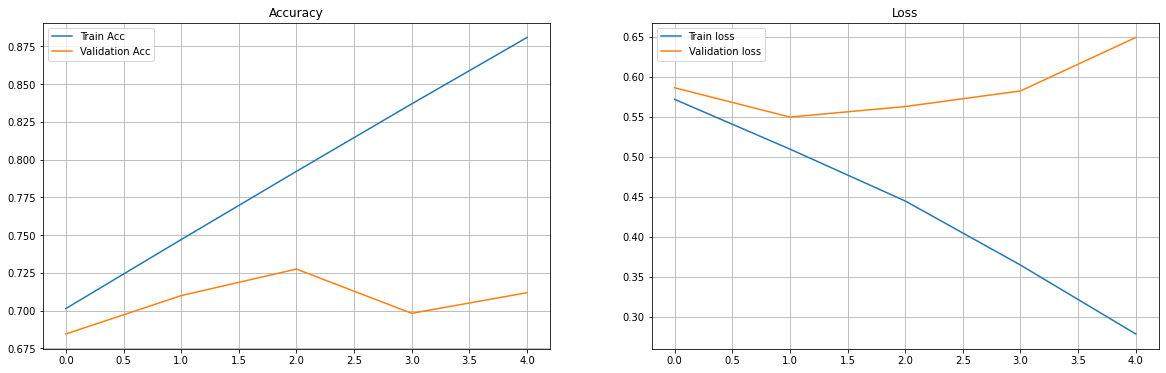

In [22]:
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc')
plt.plot(epoch_vl_acc, label='Validation Acc')
plt.title("Accuracy")
plt.legend()
plt.grid()
    
plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_vl_loss, label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()